### Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python

### Aula 13 - Forecasting - Previsões Para Séries Temporais - Modelos ARIMA

Em Estatística e Econometria, e em particular na análise de séries temporais, um modelo de média móvel integrada auto-regressiva (ARIMA) é uma generalização de um modelo de média móvel auto-regressiva (ARMA).

Ambos os modelos são ajustados a dados de séries temporais para melhor entender os dados ou para prever pontos futuros na série (previsão). Os modelos ARIMA são aplicados em alguns casos em que os dados mostram evidências de não estacionariedade, onde uma etapa inicial de diferenciação (correspondente à parte "integrada" do modelo) pode ser aplicada uma ou mais vezes para eliminar a não estacionariedade.

A parte AR do ARIMA indica que a variável de interesse em evolução é regredida com seus próprios valores defasados (isto é, anteriores). A parte MA indica que o erro de regressão é na verdade uma combinação linear de termos de erro cujos valores ocorreram contemporaneamente e em vários momentos no passado. O I (para "integrado") indica que os valores dos dados foram substituídos pela diferença entre seus valores e os valores anteriores (e esse processo de diferenciação pode ter sido executado mais de uma vez). O objetivo de cada um desses recursos é fazer com que o modelo ajuste os dados da melhor maneira possível.

Modelos ARIMA não sazonais são geralmente designados ARIMA(p, d, q), em que os parâmetros p, d e q são números inteiros não negativos, p é a ordem (número de intervalos de tempo) do modelo autoregressivo, d é o grau de diferenciação (o número de vezes que os dados tiveram valores passados subtraídos) e q é a ordem do modelo de média móvel.

Modelos ARIMA sazonais são geralmente designados ARIMA (p, d, q) (P, D, Q) m, em que m refere-se ao número de períodos em cada season e os maiúsculos P, D, Q referem-se ao autorregressivo, diferenciado, e termos da média móvel da parte sazonal do modelo ARIMA.

Quando dois dos três termos são zeros, o modelo pode ser referido com base no parâmetro diferente de zero, eliminando "AR", "I" ou "MA" da sigla que descreve o modelo. Por exemplo, ARIMA (1,0,0) é AR (1), ARIMA (0,1,0) é I (1) e ARIMA (0,0,1) é MA (1).

Os Modelos ARIMA são estudados em detalhes e aplicados em diversos e diferentes casos de uso nos cursos Análise Econométrica em R e Análise Estatística Para Data Science II. O curso de Business Analytics também tem projetos onde aplicamos Modelos ARIMA.

Teremos algumas aulas para estudar Modelos Arima. Mas já vamos começar com nosso primeiro modelo.

### Carregando os Pacotes Usados Neste Jupyter Notebook

In [1]:
# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.

!pip install -q -U watermark

You should consider upgrading via the 'c:\users\rodolfo\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [3]:
# The new versions of Pandas and Matplotlib bring several warning messages to the desenvolper. Lets's disable this. 
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports for data manipulatioo
import numpy as np
import pandas as pd
from datetime import datetime


# Imports for data vasualization
import matplotlib.pyplot as plt
import matplotlib as m

# Imports for predictive modeling
import statsmodels
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Imports for metrics and model performance
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Imports for formatting graphics 
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

In [4]:
#Versions of packages used in this jupyter notebook
%reload_ext watermark
%watermark -a "Data Scientist Rodolfo Terra" --iversions

Author: Data Scientist Rodolfo Terra

numpy      : 1.18.2
pandas     : 1.1.1
sys        : 3.7.6 (tags/v3.7.6:43364a7ae0, Dec 19 2019, 00:42:30) [MSC v.1916 64 bit (AMD64)]
sklearn    : 0.23.2
matplotlib : 3.3.1
statsmodels: 0.11.1



## Definição do Problema de Negócio

A HappyMoonVC é uma Venture Capital (VC).

Venture Capital (VC) é um tipo de fundo de investimento focado em capital de crescimento para empresas de médio porte que já possuem carteira de clientes e receita, mas que ainda precisam dar um salto de crescimento. 

VCs investem em empresas iniciantes, Startups e emergentes que foram consideradas com alto potencial de crescimento ou que demonstraram alto crescimento (em termos de número de funcionários, receita anual ou ambos).

A HappyMoonVC está analisando um novo e promissor negócio sugerido por uma Startup, o GoInRail.

O GoInRail é um método de transporte inovador que usa a tecnologia de propulsão a jato para executar um veículo similar a um Drone, mas sobre trilhos (que mantém o Drone carregado com energia elétrica) e transportar pessoas em alta velocidade!

O investimento só fará sentido se o GoInRail conseguir mais de 1 milhão de usuários mensais nos próximos 18 meses.

Nosso trabalho é analisar dados de séries temporais com a demanda de transporte em uma determinada região e prever a demanda pelo GoInRail, que ajude a HappyMoonVC a tomar sua decisão de investimento.

## Conjunto de Dados

Usaremos conjuntos de dados fictícios que mostram a demanda de clientes por transporte em uma determinada região. Para cada dia da semana, foi contabilizado quantas pessoas usaram o sistema de transporte na região. Os dados tem registros dos anos de 2017, 2018 e 2019.

São fornecidos 2 datasets:

- O primeiro possui 3 colunas, com id, data e total de clientes que usaram algum tipo de transporte. Será nossos dados de treino.

- O segundo possui 2 colunas, com id e data para os anos de 2019 e 2020. Será nosso dataset de teste.

In [5]:
# Loa the data
dados_treino = pd.read_csv("https://raw.githubusercontent.com/dsacademybr/Datasets/master/dataset4.csv")
dados_teste = pd.read_csv("https://raw.githubusercontent.com/dsacademybr/Datasets/master/dataset5.csv")

In [6]:
#Convert the Datetime column to the correct type
dados_treino['Datetime'] = pd.to_datetime(dados_treino.Datetime, format = '%d-%m-%Y %H:%M')

In [7]:
#Convert the Datetime column to the correct type
dados_teste['Datetime'] = pd.to_datetime(dados_teste.Datetime, format = '%d-%m-%Y %H:%M')

In [8]:
# Let's extract the details from the Datetime column: year, month, day and time

for i in (dados_treino, dados_teste):
    i['ano'] = i.Datetime.dt.year
    i['mes'] = i.Datetime.dt.month
    i['dia'] = i.Datetime.dt.day
    i['hora'] = i.Datetime.dt.hour

In [9]:
# We need the day of the week too
dados_treino['dia_semana'] = dados_treino['Datetime'].dt.dayofweek

In [10]:
# It would be good to check if the fact that it is a weekend or not impacts the use of transportation.
# Let's extract this information. Days of the week equal to 5 or 6 are Saturday and Sunday.

# We created a function, where we mark weekends as 1 and working days as 0
def converteFimSemana(registro):
    if registro.dayofweek == 5 or registro.dayofweek == 6:
        return 1
    else:
        return 0

In [11]:
# Now we apply the function
dados_treino['final_semana'] = dados_treino['Datetime'].apply(converteFimSemana)

In [12]:
# Let's see how the dataset looks
dados_treino.head()

,ID,Datetime,Count,ano,mes,dia,hora,dia_semana,final_semana
0,0,2017-08-25 00:00:00,8,2017,8,25,0,4,0
1,1,2017-08-25 01:00:00,2,2017,8,25,1,4,0
2,2,2017-08-25 02:00:00,6,2017,8,25,2,4,0
3,3,2017-08-25 03:00:00,2,2017,8,25,3,4,0
4,4,2017-08-25 04:00:00,2,2017,8,25,4,4,0


In [13]:
# We refine the data for the original series chart

# We define the index of the dataset
dados_treino.index = dados_treino['Datetime']

# We removed the ID column, as it is not relevant in this case
features = dados_treino.drop('ID',1)

# The Count variable is our target variable (total people who used transportation)
target = dados_treino['Count']

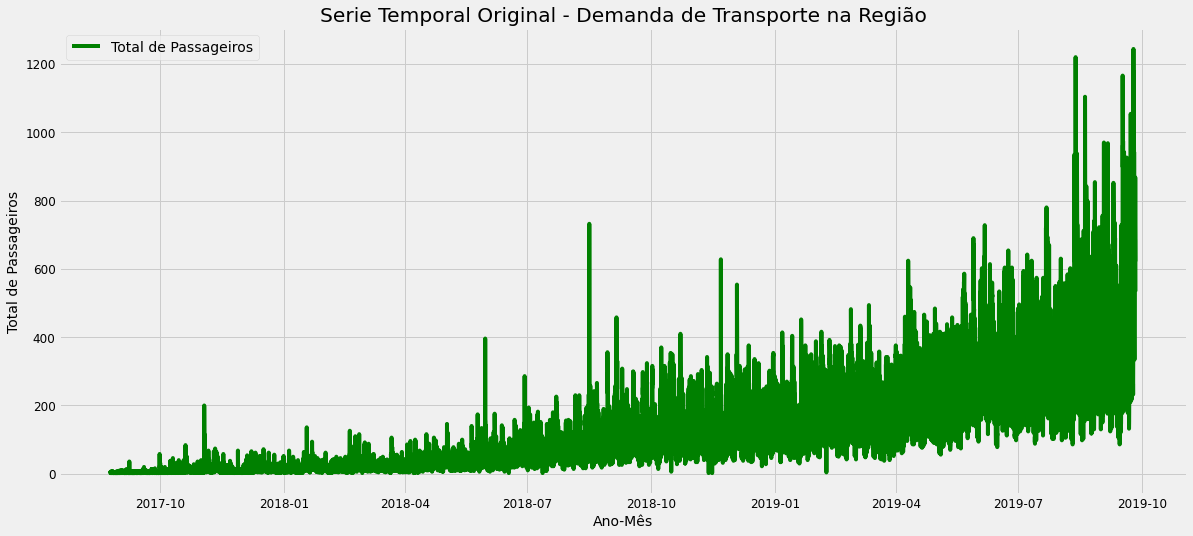

In [14]:
# Plot
plt.title("Serie Temporal Original - Demanda de Transporte na Região")
plt.plot(target, label = "Total de Passageiros", color = 'green')
plt.xlabel("Ano-Mês")
plt.ylabel("Total de Passageiros")
plt.legend(loc = "best")

In [15]:
# Function to test stationarity

def testa_estacionaridade(serie):
    
    # Calculates mobile statistcs
    rolmean = serie.rolling(window = 12).mean()
    rolstd = serie.rolling(window = 12).std()
    
    # Plot of mobile statistics
    orig = plt.plot(serie, color ='blue', label = "Original")
    mean = plt.plot(rolmean, color = 'red', label = 'Média Padrão')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Dickey-Fuller teste:
    # Print
    print(('\nResultado do Teste Dickey-Fuller:\n'))
    
    # Test
    dfteste = adfuller(serie,autolag = 'AIC')
    
    # Formatting the output
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])
    
    # Loop for each test output item 
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)' %key] = value
        
    # Print
    print(dfsaida)
    
    # Tests the p-value
    print('\nConclusão:')
    if dfsaida[1] >0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

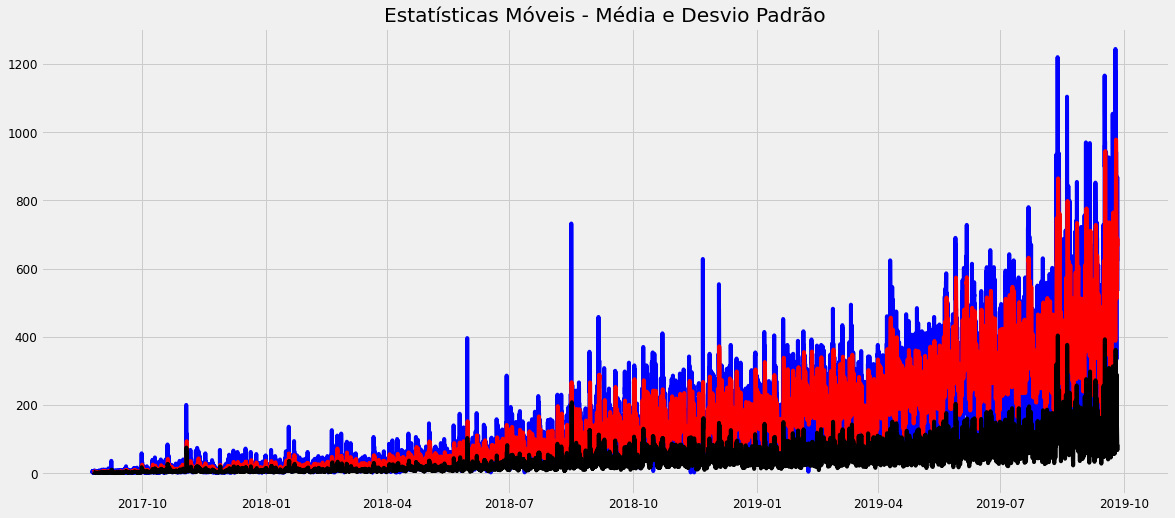


Resultado do Teste Dickey-Fuller:

Estatística do Teste               -4.456561
Valor-p                             0.000235
Número de Lags Consideradas        45.000000
Número de Observações Usadas    18242.000000
Valor Crítico (1%)                 -3.430709
Valor Crítico (5%)                 -2.861698
Valor Crítico (10%)                -2.566854
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [16]:
# Apply the function
testa_estacionaridade(dados_treino['Count'])

A série já é estacionária.

Vamos decompor a série e analisar seus componentes em separado.

### Pré-Processamento

In [18]:
# Training data will be divided into training and validation data.
# Note that the records are separated in chronological order.
df_treino = dados_treino.iloc[0:16057]
df_valid = dados_treino.iloc[16058:]

In [19]:
df_treino.shape

(16057, 9)

In [21]:
df_valid.shape

(2230, 9)

Para Modelos ARIMA, devemos remover a tendência. Vamos fazer isso.

In [22]:
# Applyng log transformation
df_treino_log = np.log(df_treino['Count'])

In [23]:
# Moving Average

media_movel = df_treino_log.rolling(24).mean()

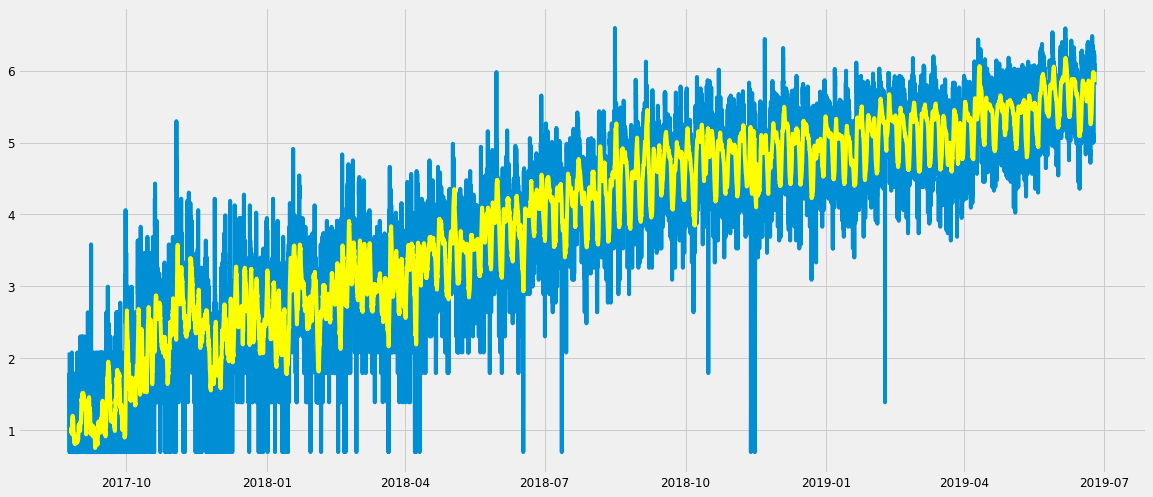

In [25]:
# Plot
plt.plot(df_treino_log)
plt.plot(media_movel, color = 'yellow')
plt.show()

Agora aplicamos a diferenciação.

In [28]:
# Differentiation
df_treino_media_movel_diff = df_treino_log - media_movel
df_treino_media_movel_diff.dropna(inplace = True)

In [30]:
# Using the shift function to move the series in 1 and calculate the difference
df_treino_log_diff = df_treino_log - df_treino_log.shift(1) 

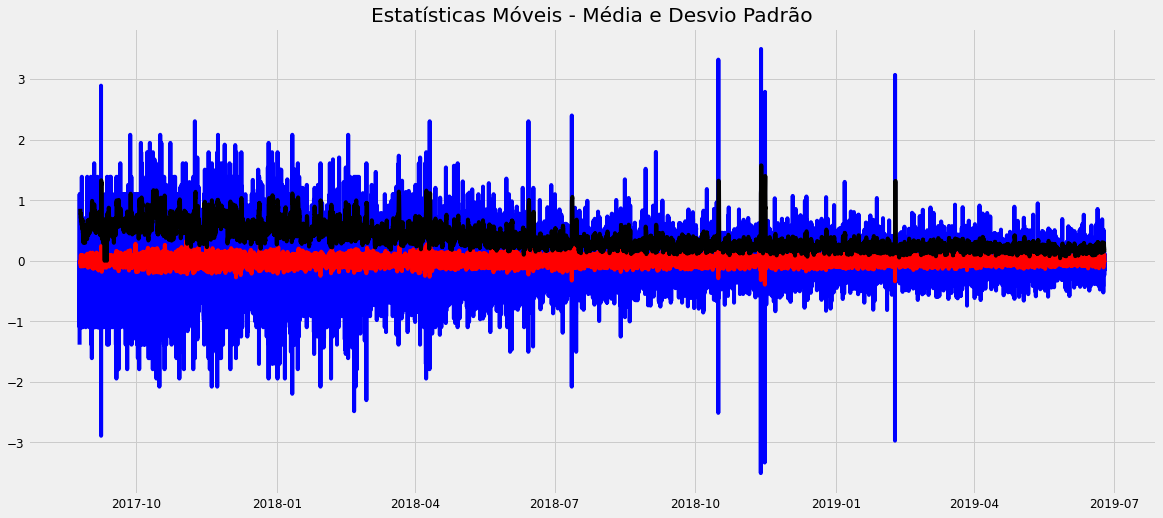


Resultado do Teste Dickey-Fuller:

Estatística do Teste              -28.580228
Valor-p                             0.000000
Número de Lags Consideradas        43.000000
Número de Observações Usadas    16012.000000
Valor Crítico (1%)                 -3.430758
Valor Crítico (5%)                 -2.861721
Valor Crítico (10%)                -2.566866
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [31]:
# Apply the function
testa_estacionaridade(df_treino_log_diff.dropna())

Perfeito. Tendência removida da série. 

## Forecasting - Modelagem Preditiva Para Séries Temporais

### Modelo ARIMA

Vamos criar nosso primeiro Modelo ARIMA. Para começar vamos criar um modelo simples, treiná-los e fazer previsões e nas aulas seguintes vamos explorar os detalhes de Modelos ARIMA, como interpretar o resultado, os resíduos e melhorar o modelo.

https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html

In [32]:
# Create the ARIMA Model

# Definimos:

# p = 2
# d = 1
# q = 0

# Aqui o valor q é zero, pois é apenas o modelo AR. Nas próximas aulas eu explico porque.

# Modelo
modelo_AR = ARIMA(df_treino_log, order  = (2,1,0), freq = 'H')

Você pode estar se perguntando: Mas por que usamos os dados originais aqui? Não deveríamos usar a série diferenciada?

De forma bem clara e objetiva, a resposta é: Não.

Realizamos todas essas etapas de diferenciação e outras transformações para descobrir os coeficientes do modelo ARIMA.

'I' no ARIMA significa Integração, que leva em consideração o número de dados diferenciados necessários para se tornar a série estacionária (ou seja, o Modelo ARIMA faz todo o trabalho).

Realizamos essas etapas de diferenciação no início para encontra o valor ideal de "I". De fato, você deve comparar modelos diferentes com valores diferentes dessas variáveis para obter o melhor modelo.

O Pré-Processamento que fazemos nas séries temporais é para encontrar os melhores valores de p, d e q que colocamos aqui: order = (2, 1, 0).

Portanto, treinamos o modelo com TODOS os dados, a série inteira (dados de treino). Estudaremos isso nas aulas seguintes.

In [33]:
# Training
modelo_v1 = modelo_AR.fit(disp = -1)

In [34]:
# Actual Data and Forecasts
dados_reais = df_treino_log_diff
previsoes = modelo_v1.fittedvalues

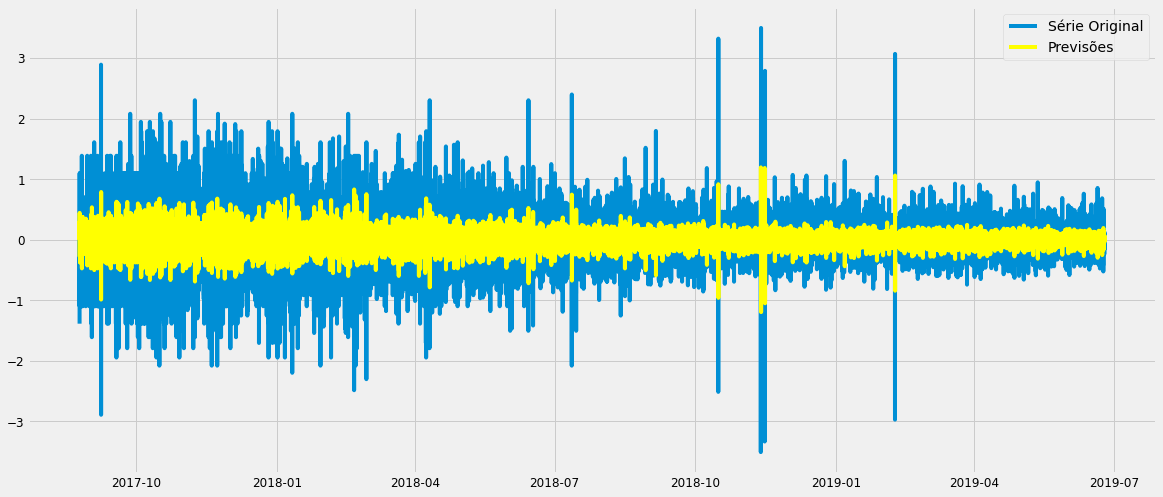

In [35]:
# Plot
plt.plot(dados_reais, label = 'Série Original') 
plt.plot(previsoes, color = 'yellow', label = 'Previsões') 
plt.legend(loc = 'best') 
plt.show()

In [36]:
# Summary of the Model - In the next classes we will interpret this summary of the model
modelo_v1.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARIMA
====================================================================
Model:              ARIMA            BIC:                 16277.4337
Dependent Variable: D.Count          Log-Likelihood:      -8119.3   
Date:               2020-12-02 20:07 Scale:               1.0000    
No. Observations:   16056            Method:              css-mle   
Df Model:           3                Sample:              08-25-2017
Df Residuals:       16053                                 06-25-2019
Converged:          1.0000           S.D. of innovations: 0.401     
No. Iterations:     6.0000           HQIC:                16256.862 
AIC:                16246.6983                                      
---------------------------------------------------------------------
                 Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
---------------------------------------------------------------------
const            0.0003    0.0022    0.1143  0.9090  -0.0041   0.0047
ar.L1.D.Count   -0.3419    0.0079  -43.4205  0.0000  -0.3573  -0.3265
ar.L2.D.Count   -0.0695    0.0079   -8.8300  0.0000  -0.0850  -0.0541
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1           -2.4583            -2.8874           3.7921            -0.3623
AR.2           -2.4583             2.8874           3.7921             0.3623
====================================================================

"""

Agora vamos fazer previsões com o modelo treinado.

https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARMAResults.forecast.html

In [37]:
# You know that the transformations applied to the training data must be applied to the validation / test data
df_valid_log = np.log(df_valid['Count'])

In [38]:
# Forecast
# The alpha parameter represents the confidence interval, in this case, 95%
fc, se, conf = modelo_v1.forecast(len(df_valid), alpha = 0.05)

In [39]:
# forecast
fc

array([5.85341812, 5.848469  , 5.8471654 , ..., 6.4184945 , 6.41875096,
       6.41900742])

In [40]:
# error
se

array([ 0.40121703,  0.48030433,  0.55749783, ..., 13.42013149,
       13.42314169, 13.42615122])

In [41]:
# Coefficient
conf

array([[  5.0670472 ,   6.63978905],
       [  4.90708981,   6.78984819],
       [  4.75448974,   6.93984106],
       ...,
       [-19.88447988,  32.72146888],
       [-19.89012332,  32.72762523],
       [-19.89576543,  32.73378026]])

In [42]:
# We need to create a dataframe to create the Plot
fc_series = pd.Series(fc, index = df_valid.index)
limite_inferior = pd.Series(conf[:, 0], index = df_valid.index)
limite_superior = pd.Series(conf[:, 1], index = df_valid.index)

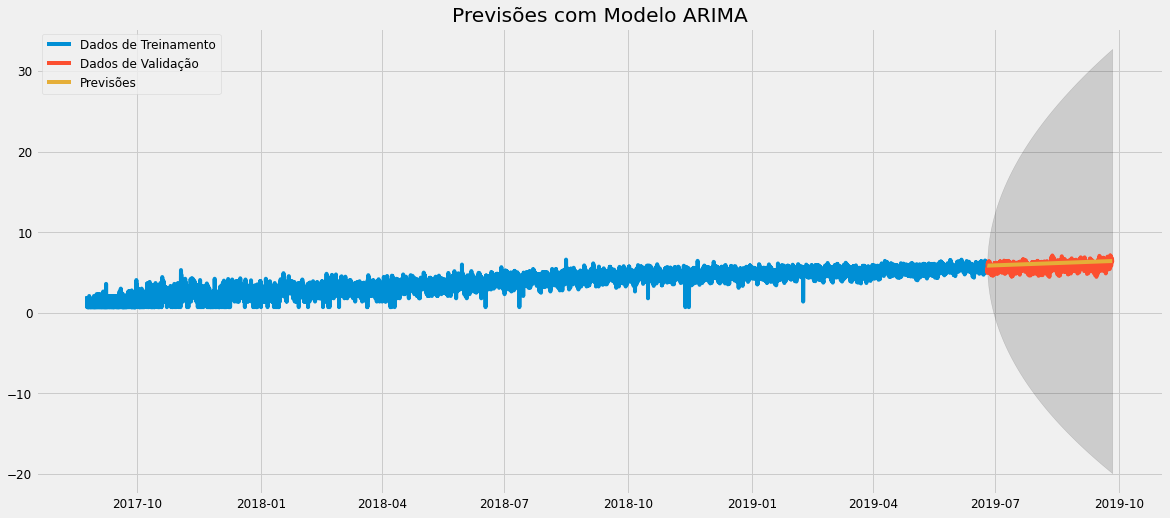

In [43]:
# Plot
plt.plot(df_treino_log, label = 'Dados de Treinamento')
plt.plot(df_valid_log, label = 'Dados de Validação')
plt.plot(fc_series, label = 'Previsões')
plt.fill_between(limite_inferior.index, limite_inferior, limite_superior, color = 'k', alpha = .15)
plt.title('Previsões com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

emos a previsão da nossa série! Nosso modelo está muito bom e poderia ser usado para resolver nosso problema de negócio.



In [44]:
# Dfines actual and predicted value
y_true = df_valid_log
y_pred = fc_series

In [45]:
# Calculates the error using RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

0.5577789477133491


Opa! Reduzimos de forma considerável o erro do nosso modelo. Não é por acaso que Modelos ARIMA fazem tanto sucesso.

Você pode estar estranhando o gráfico, mas o que fizemos foi usar a série com a transformação de log, o que muda a escala dos dados. Porém os dados são os mesmos.

Nas próximas aulas vou trazer diversos conceitos ligados a este tipo de modelo.